# Data Collection and Preprocessing in Portfolio Optimization

This notebook provides a detailed explanation of how we collect and preprocess financial data for portfolio optimization. We'll explore:

1. Understanding the `DataCollector` class
2. Fetching data from Yahoo Finance
3. Calculating returns at different frequencies
4. Data cleaning and validation
5. Basic statistical analysis

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from portfolio_optimization.data import DataCollector, setup_logger as data_logger
from scipy import stats

# Set plotting style
plt.style.use('ggplot')
sns.set_palette('husl')

# Initialize logger
data_logger = data_logger(console_level=None)

# Setting pandas display options
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 10)
pd.set_option('display.float_format', '{:,.2f}'.format)


## 1. Understanding the DataCollector Class

The `DataCollector` class is responsible for:
- Loading configuration settings
- Fetching historical price data
- Calculating returns
- Saving processed data

Let's examine how it works:

In [2]:
# Initialize DataCollector
collector = DataCollector()

# Display configuration settings
print("Data Collection Settings:")
print(f"Start Date: {collector.start_date}")
print(f"End Date: {collector.end_date}")
print(f"Price Column: {collector.price_col}")

Data Collection Settings:
Start Date: 2010-01-01
End Date: 2023-12-31
Price Column: Adj Close


## 2. Fetching Data from Yahoo Finance

We use the `yfinance` library to fetch historical price data. Let's see how this works:

In [3]:
collector.config['universe']

{'n_stocks': 6,
 'stocks': ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA'],
 'etfs': ['AGG', 'DBC', 'UUP']}

In [4]:
# Get list of tickers
tickers = collector.config['universe']['stocks']
print("Selected Tickers:", tickers)

# Fetch data
prices = collector.fetch_data(tickers)

# Display first few rows
print("\nPrice Data Sample:")
print(prices.head())

# Basic statistics
print("\nPrice Statistics:")
prices.describe()

Selected Tickers: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA']

Price Data Sample:
            AAPL  MSFT  GOOGL  AMZN  META  NVDA
Date                                           
2010-01-04  6.45 23.30  15.63  6.70   NaN  0.42
2010-01-05  6.46 23.31  15.56  6.73   NaN  0.43
2010-01-06  6.36 23.17  15.17  6.61   NaN  0.43
2010-01-07  6.34 22.92  14.81  6.50   NaN  0.42
2010-01-08  6.39 23.08  15.01  6.68   NaN  0.43

Price Statistics:


,AAPL,MSFT,GOOGL,AMZN,META,NVDA
count,"3,522.00","3,522.00","3,522.00","3,522.00","2,923.00","3,522.00"
mean,57.64,109.17,53.91,63.35,157.09,7.27
std,55.58,101.89,38.96,54.77,90.58,10.89
min,5.79,17.48,10.87,5.43,17.66,0.20
25%,16.97,27.22,21.86,14.13,80.46,0.39
50%,29.07,56.79,40.86,40.91,152.94,2.44
75%,88.87,193.55,73.65,99.84,204.03,9.50
max,197.14,379.86,149.30,186.57,380.73,50.39


In [5]:
# Get sp500 ticker
sp500_ticker_symbol = '^GSPC'

# Fetch data
sp500_prices = collector.fetch_data([sp500_ticker_symbol])

# Display first few rows
print("\nPrice Data Sample:")
print(sp500_prices.head())

# Basic statistics
print("\nPrice Statistics:")
print(sp500_prices.describe())


Price Data Sample:
              ^GSPC
Date               
2010-01-04 1,132.99
2010-01-05 1,136.52
2010-01-06 1,137.14
2010-01-07 1,141.69
2010-01-08 1,144.98

Price Statistics:
         ^GSPC
count 3,522.00
mean  2,535.09
std   1,070.52
min   1,022.58
25%   1,650.48
50%   2,264.48
75%   3,274.37
max   4,796.56


### Visualizing Price Data

Let's create some visualizations to understand our price data:

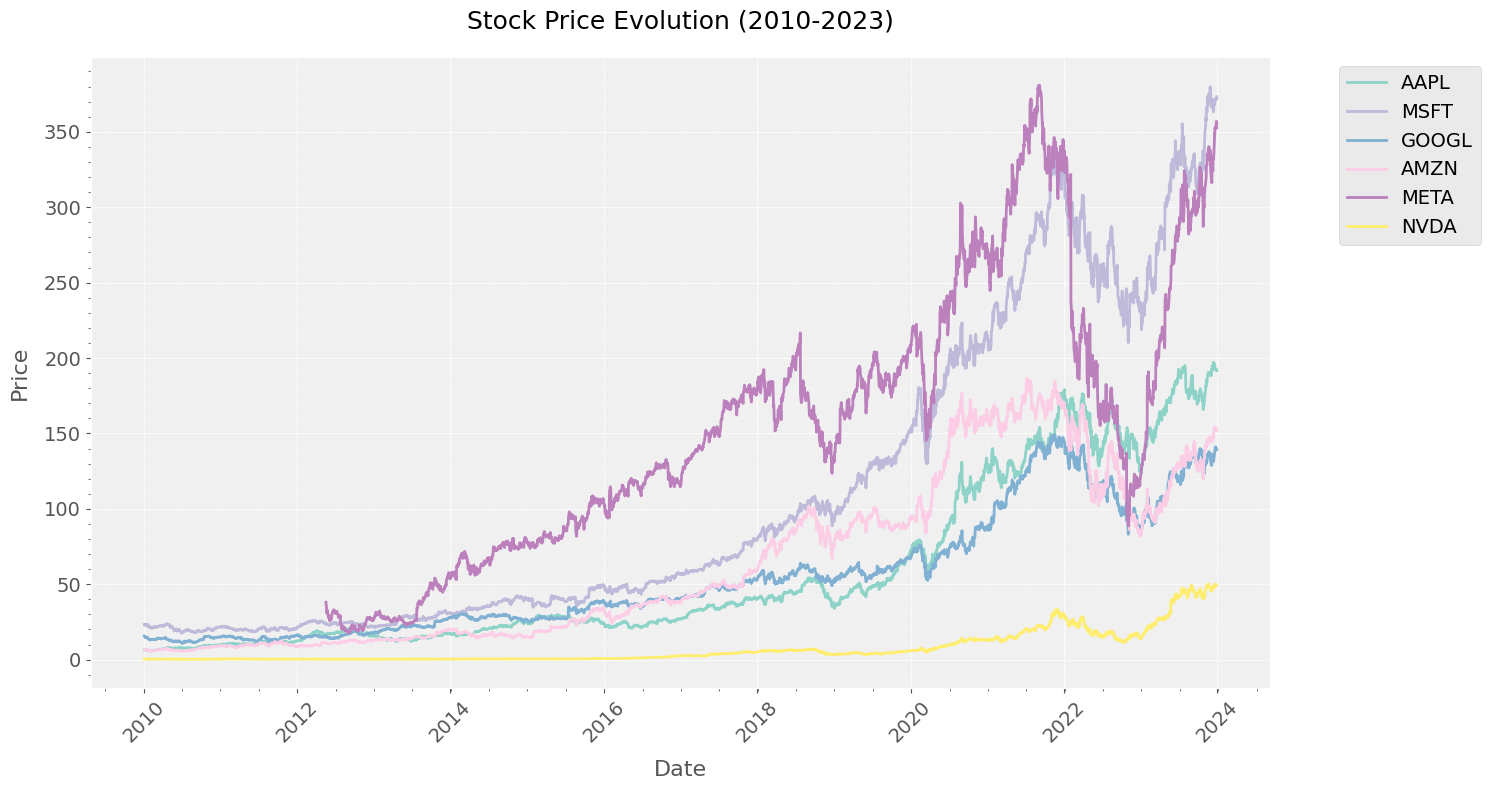

In [6]:
# Plot price evolution with improved styling
fig, ax = plt.subplots(figsize=(15, 8))

# Create color palette
colors = plt.cm.Set3(np.linspace(0, 1, len(prices.columns)))

for column, color in zip(prices.columns, colors):
    ax.plot(prices.index, prices[column], label=column, 
            linewidth=2, color=color)

# Enhance the plot appearance
ax.set_title('Stock Price Evolution (2010-2023)', 
             fontsize=18, pad=20)
ax.set_xlabel('Date', fontsize=16, labelpad=10)
ax.set_ylabel('Price', fontsize=16, labelpad=10)

# Improve legend
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
         fontsize=14, frameon=True)

# Add major and minor gridlines
ax.grid(True, which='major', linestyle='-', alpha=0.7)
ax.grid(True, which='minor', linestyle=':', alpha=0.4)
ax.minorticks_on()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

# Add background shading
ax.set_facecolor('#f0f0f0')
fig.patch.set_facecolor('white')

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

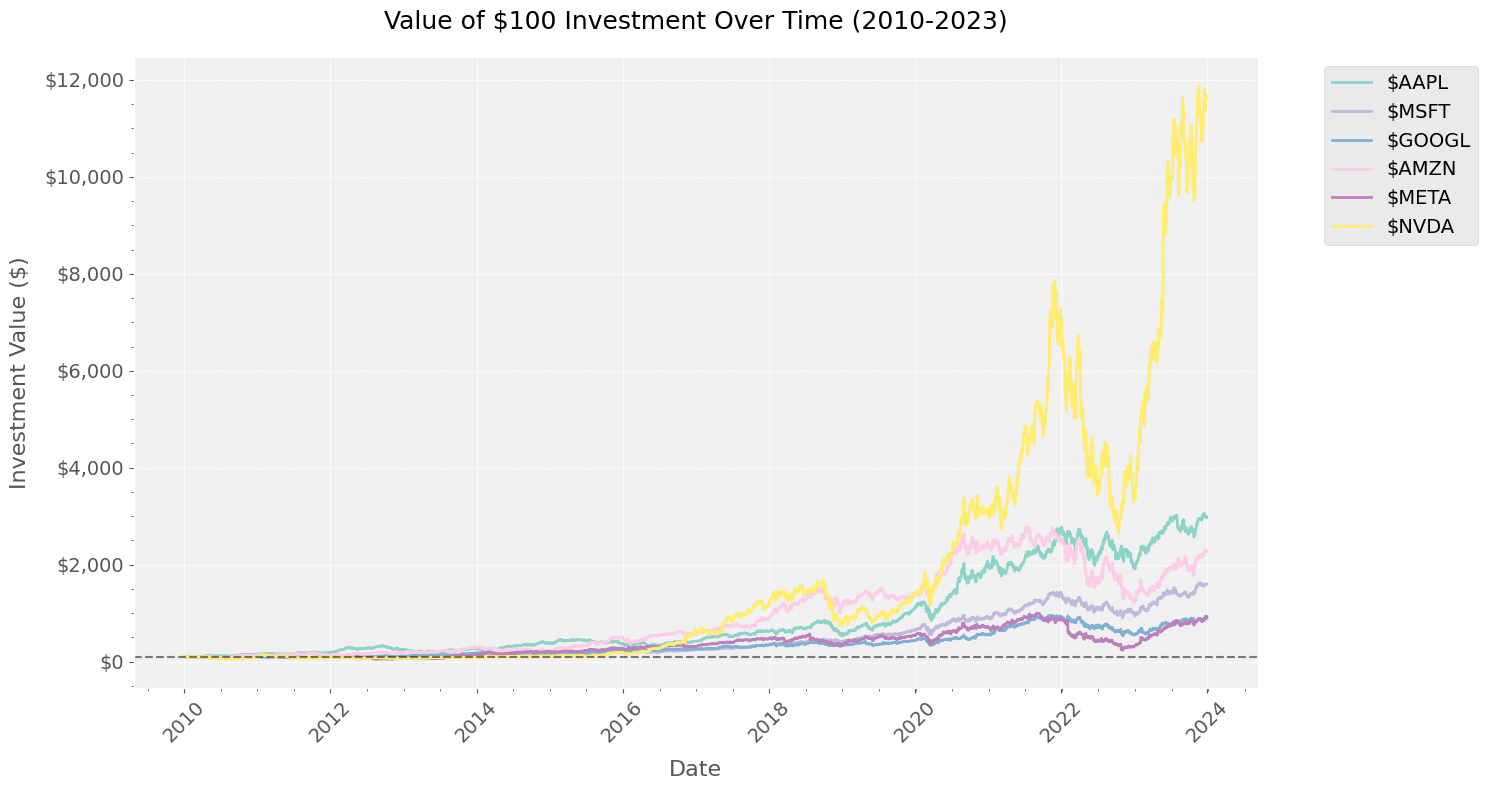


Final value of $100 investment:
AAPL (from 2010-01-04): $2,971.60
MSFT (from 2010-01-04): $1,601.88
GOOGL (from 2010-01-04): $890.63
AMZN (from 2010-01-04): $2,269.45
META (from 2012-05-18): $925.87
NVDA (from 2010-01-04): $11,678.54


In [7]:
# Calculate normalized prices (starting from $100 investment)
# Handle stocks that start at different dates by normalizing from their first available price
normalized_prices = pd.DataFrame()
for column in prices.columns:
    # Get first non-null value index
    first_valid_idx = prices[column].first_valid_index()
    # Normalize from first available price
    normalized_prices[column] = prices[column].div(prices[column].loc[first_valid_idx]) * 100

# Plot normalized price evolution
fig, ax = plt.subplots(figsize=(15, 8))

# Create color palette
colors = plt.cm.Set3(np.linspace(0, 1, len(normalized_prices.columns)))

for column, color in zip(normalized_prices.columns, colors):
    ax.plot(normalized_prices.index, normalized_prices[column], 
            label=f'${column}', linewidth=2, color=color)

# Enhance the plot appearance
ax.set_title('Value of $100 Investment Over Time (2010-2023)', 
             fontsize=18, pad=20)
ax.set_xlabel('Date', fontsize=16, labelpad=10)
ax.set_ylabel('Investment Value ($)', fontsize=16, labelpad=10)

# Improve legend
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
         fontsize=14, frameon=True)

# Add major and minor gridlines
ax.grid(True, which='major', linestyle='-', alpha=0.7)
ax.grid(True, which='minor', linestyle=':', alpha=0.4)
ax.minorticks_on()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

# Add background shading
ax.set_facecolor('#f0f0f0')
fig.patch.set_facecolor('white')

# Add horizontal line at $100 to show initial investment
ax.axhline(y=100, color='black', linestyle='--', alpha=0.5)

# Format y-axis with dollar signs
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${int(x):,}'))

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

# Print final values
final_values = normalized_prices.iloc[-1].round(2)
print("\nFinal value of $100 investment:")
for stock, value in final_values.items():
    # Get start date for each stock
    start_date = prices[stock].first_valid_index().strftime('%Y-%m-%d')
    print(f"{stock} (from {start_date}): ${value:,.2f}")


### Visualizing S&P 500


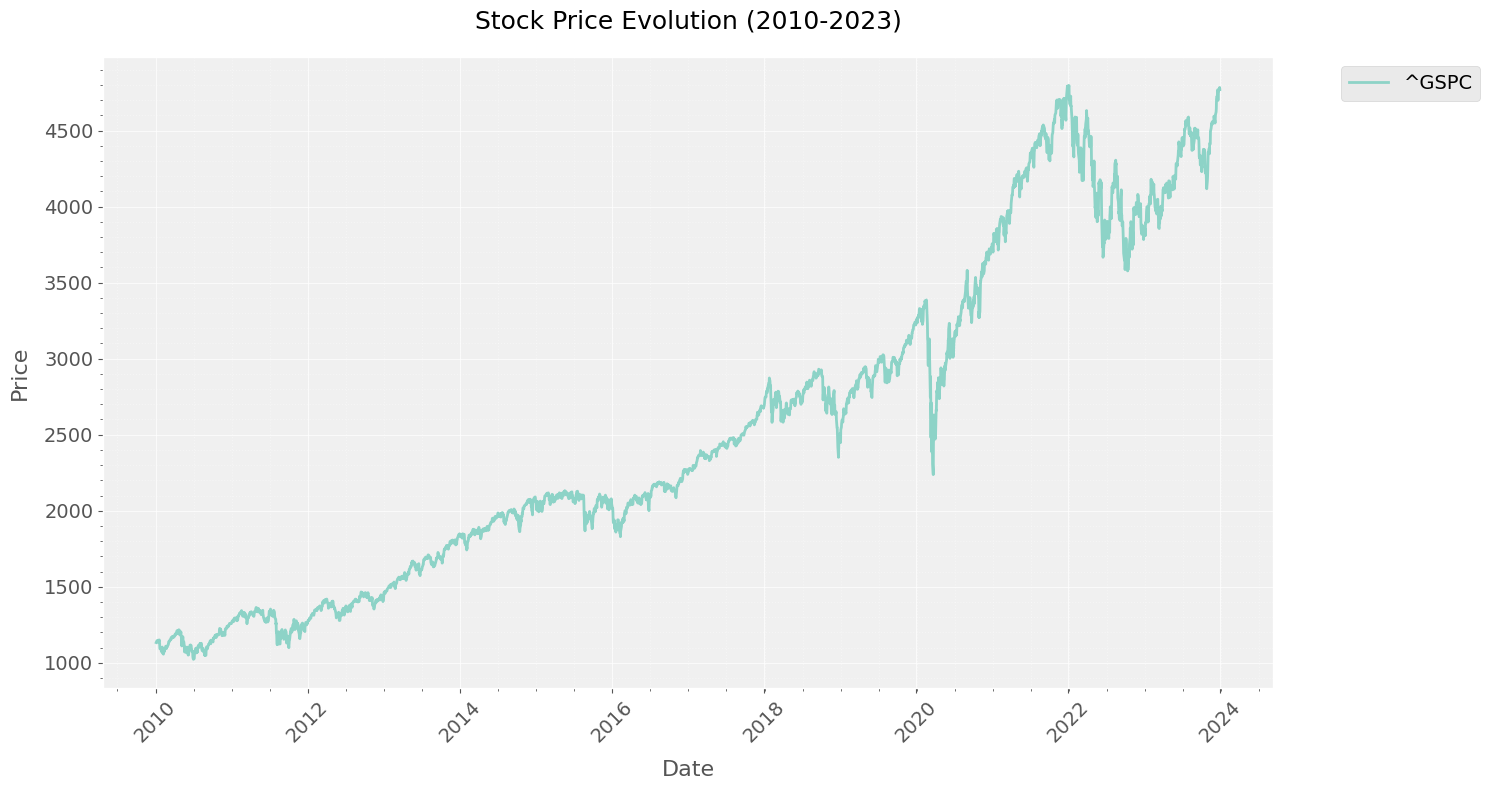

In [8]:
# Plot price evolution with improved styling
fig, ax = plt.subplots(figsize=(15, 8))

# Create color palette
colors = plt.cm.Set3(np.linspace(0, 1, len(sp500_prices.columns)))

for column, color in zip(sp500_prices.columns, colors):
    ax.plot(sp500_prices.index, sp500_prices[column], label=column, 
            linewidth=2, color=color)

# Enhance the plot appearance
ax.set_title('Stock Price Evolution (2010-2023)', 
             fontsize=18, pad=20)
ax.set_xlabel('Date', fontsize=16, labelpad=10)
ax.set_ylabel('Price', fontsize=16, labelpad=10)

# Improve legend
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
         fontsize=14, frameon=True)

# Add major and minor gridlines
ax.grid(True, which='major', linestyle='-', alpha=0.7)
ax.grid(True, which='minor', linestyle=':', alpha=0.4)
ax.minorticks_on()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

# Add background shading
ax.set_facecolor('#f0f0f0')
fig.patch.set_facecolor('white')

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

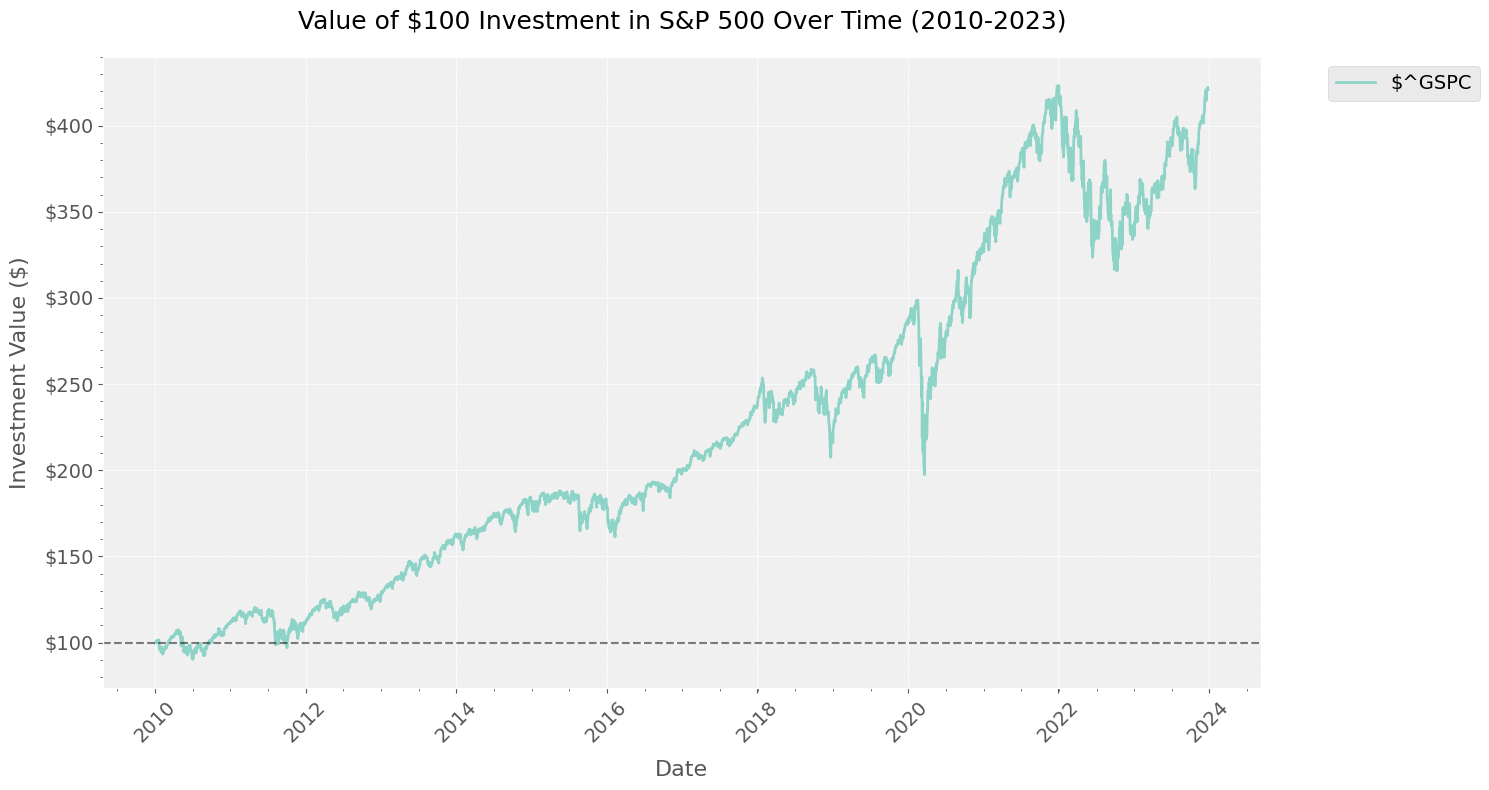


Final value of $100 investment in S&P 500:
^GSPC: $420.99


In [9]:
# Calculate normalized prices (starting from $100 investment)
normalized_sp500_prices = sp500_prices.div(sp500_prices.iloc[0]) * 100

# Plot normalized price evolution
fig, ax = plt.subplots(figsize=(15, 8))

# Create color palette
colors = plt.cm.Set3(np.linspace(0, 1, len(normalized_sp500_prices.columns)))

for column, color in zip(normalized_sp500_prices.columns, colors):
    ax.plot(normalized_sp500_prices.index, normalized_sp500_prices[column], 
            label=f'${column}', linewidth=2, color=color)

# Enhance the plot appearance
ax.set_title('Value of $100 Investment in S&P 500 Over Time (2010-2023)', 
             fontsize=18, pad=20)
ax.set_xlabel('Date', fontsize=16, labelpad=10)
ax.set_ylabel('Investment Value ($)', fontsize=16, labelpad=10)

# Improve legend
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
         fontsize=14, frameon=True)

# Add major and minor gridlines
ax.grid(True, which='major', linestyle='-', alpha=0.7)
ax.grid(True, which='minor', linestyle=':', alpha=0.4)
ax.minorticks_on()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

# Add background shading
ax.set_facecolor('#f0f0f0')
fig.patch.set_facecolor('white')

# Add horizontal line at $100 to show initial investment
ax.axhline(y=100, color='black', linestyle='--', alpha=0.5)

# Format y-axis with dollar signs
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${int(x):,}'))

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

# Print final values
final_values = normalized_sp500_prices.iloc[-1].round(2)
print("\nFinal value of $100 investment in S&P 500:")
for stock, value in final_values.items():
    print(f"{stock}: ${value:,.2f}")


## 3. Calculating Returns

We calculate returns at different frequencies (daily, weekly, monthly). Let's understand how this works:

In [10]:
# Calculate returns at different frequencies
daily_returns = collector.calculate_returns(prices, 'daily')
weekly_returns = collector.calculate_returns(prices, 'weekly')
monthly_returns = collector.calculate_returns(prices, 'monthly')

# Display summary statistics
print("Daily Returns Statistics:")
daily_returns.describe()

Daily Returns Statistics:


,AAPL,MSFT,GOOGL,AMZN,META,NVDA
count,"2,922.00","2,922.00","2,922.00","2,922.00","2,922.00","2,922.00"
mean,0.00,0.00,0.00,0.00,0.00,0.00
std,0.02,0.02,0.02,0.02,0.03,0.03
min,-0.13,-0.15,-0.12,-0.14,-0.26,-0.19
25%,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01
50%,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.01,0.01,0.01,0.01,0.01,0.02
max,0.12,0.14,0.16,0.14,0.30,0.30


In [11]:
# Annualized statistics
print("\nAnnualized Statistics:")
print("Mean Returns:")
print((daily_returns.mean() * 252)*100)
print("\nVolatility:")
print((daily_returns.std() * np.sqrt(252))*100)


Annualized Statistics:
Mean Returns:
AAPL    25.47
MSFT    27.43
GOOGL   22.90
AMZN    28.11
META    27.26
NVDA    54.41
dtype: float64

Volatility:
AAPL    28.41
MSFT    26.59
GOOGL   27.11
AMZN    32.35
META    40.13
NVDA    44.16
dtype: float64


### Calculating S&P 500 Returns

In [12]:
# Calculate returns at different frequencies
sp500_daily_returns = collector.calculate_returns(sp500_prices, 'daily')
sp500_weekly_returns = collector.calculate_returns(sp500_prices, 'weekly')
sp500_monthly_returns = collector.calculate_returns(sp500_prices, 'monthly')

# Display summary statistics
print("Daily Returns Statistics:")
sp500_daily_returns.describe()

Daily Returns Statistics:


,^GSPC
count,"3,521.00"
mean,0.00
std,0.01
min,-0.12
25%,-0.00
50%,0.00
75%,0.01
max,0.09


In [13]:
# Annualized statistics
print("\nAnnualized Statistics:")
print("Mean Returns:")
print((sp500_daily_returns.mean() * 252)*100)
print("\nVolatility:")
print((sp500_daily_returns.std() * np.sqrt(252))*100)


Annualized Statistics:
Mean Returns:
^GSPC   11.83
dtype: float64

Volatility:
^GSPC   17.52
dtype: float64


### Visualizing Returns Distribution

Let's examine the distribution of returns:

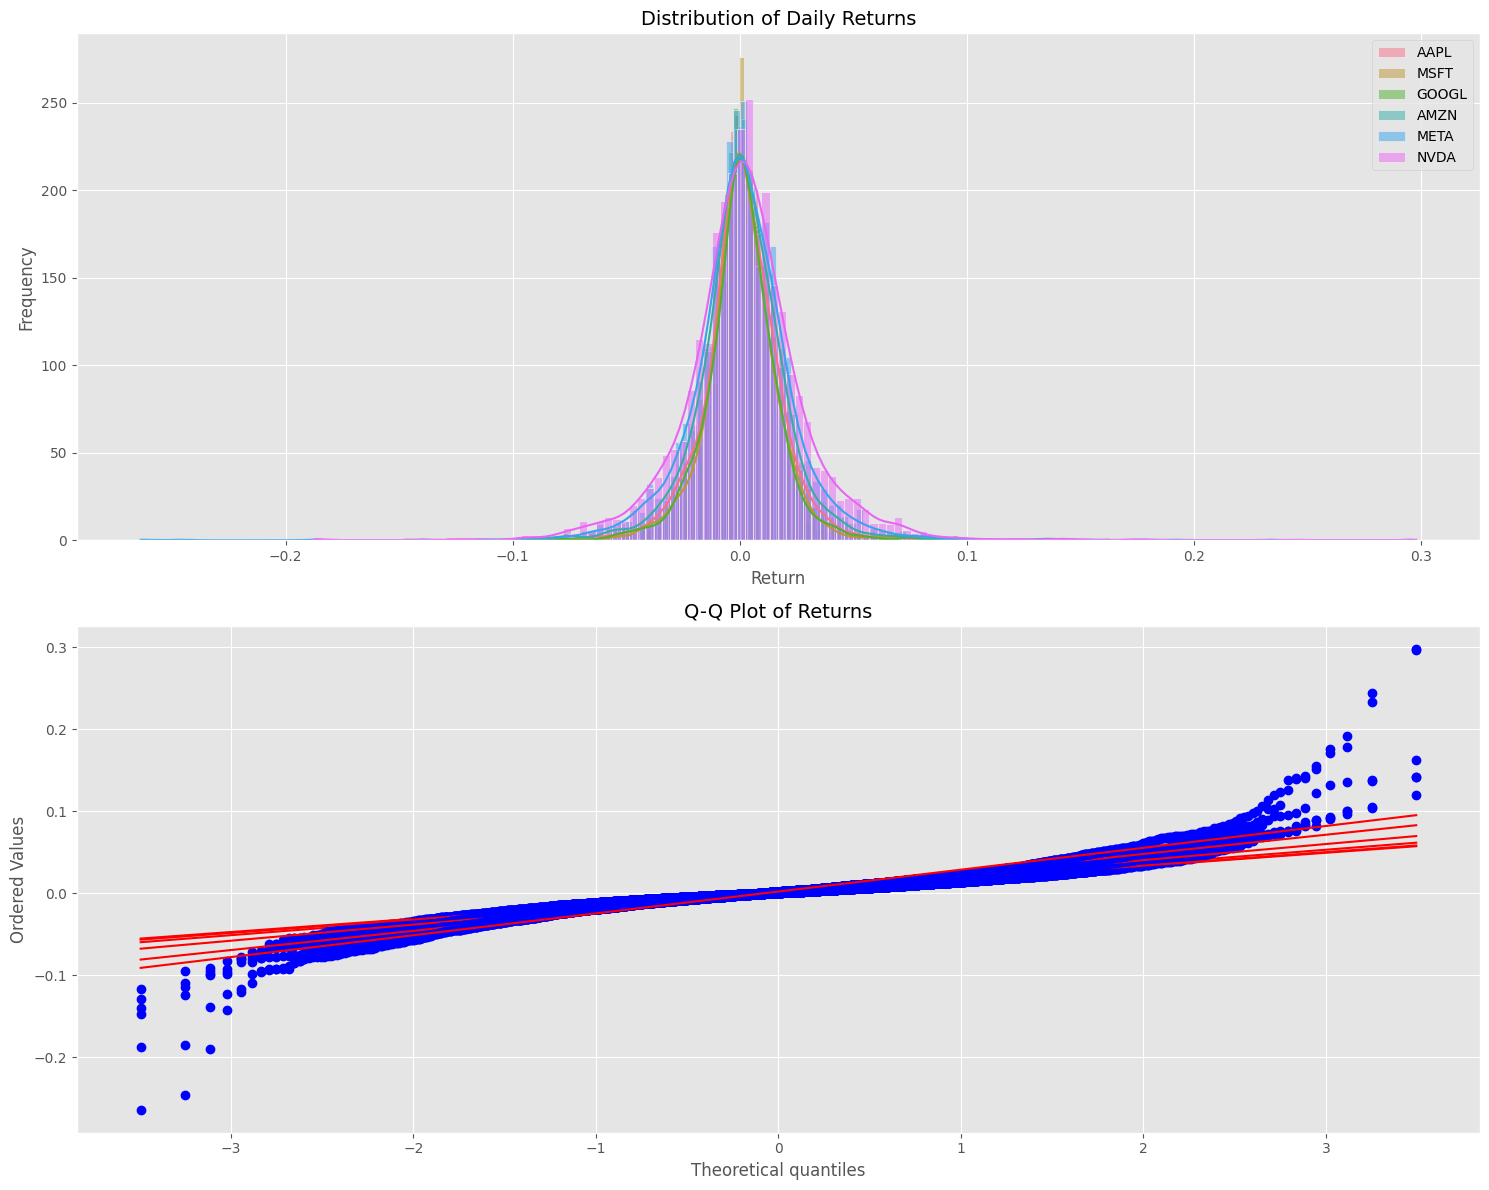

In [14]:
# Plot return distributions
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Histogram of daily returns
for column in daily_returns.columns:
    sns.histplot(data=daily_returns[column], label=column, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Daily Returns', fontsize=14)
axes[0].set_xlabel('Return', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].legend()

# Q-Q plot to check for normality
for column in daily_returns.columns:
    stats.probplot(daily_returns[column].dropna(), dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot of Returns', fontsize=14)

plt.tight_layout()
plt.show()

## 4. Data Cleaning and Validation

Let's examine our data cleaning process:

In [15]:
# Check for missing values
print("Missing Values in Price Data:")
print(prices.isnull().sum())

print("\nMissing Values in Returns:")
print(daily_returns.isnull().sum())

# Check for extreme values
print("\nExtreme Daily Returns (>3 std):")
mean = daily_returns.mean()
std = daily_returns.std()
extremes = daily_returns[((daily_returns - mean).abs() > 3 * std).any(axis=1)]
print(len(extremes))

# Group extreme periods by financial quarter
print("\nTime Periods of Extreme Returns by Quarter:")
quarters = extremes.index.to_period('Q')
quarter_groups = extremes.groupby(quarters).size()
for quarter, count in quarter_groups.items():
    print(f"{quarter.year}-Q{quarter.quarter}: {count} extreme events")


Missing Values in Price Data:
AAPL       0
MSFT       0
GOOGL      0
AMZN       0
META     599
NVDA       0
dtype: int64

Missing Values in Returns:
AAPL     0
MSFT     0
GOOGL    0
AMZN     0
META     0
NVDA     0
dtype: int64

Extreme Daily Returns (>3 std):
161

Time Periods of Extreme Returns by Quarter:
2012-Q2: 3 extreme events
2012-Q3: 5 extreme events
2012-Q4: 7 extreme events
2013-Q1: 2 extreme events
2013-Q2: 2 extreme events
2013-Q3: 4 extreme events
2013-Q4: 2 extreme events
2014-Q1: 3 extreme events
2014-Q2: 2 extreme events
2014-Q3: 2 extreme events
2014-Q4: 1 extreme events
2015-Q1: 3 extreme events
2015-Q2: 1 extreme events
2015-Q3: 6 extreme events
2015-Q4: 2 extreme events
2016-Q1: 5 extreme events
2016-Q2: 4 extreme events
2016-Q3: 2 extreme events
2016-Q4: 1 extreme events
2017-Q1: 2 extreme events
2017-Q2: 1 extreme events
2017-Q4: 1 extreme events
2018-Q1: 4 extreme events
2018-Q2: 1 extreme events
2018-Q3: 2 extreme events
2018-Q4: 11 extreme events
2019-Q1: 4 ex

## 5. Correlation Analysis

Understanding correlations between assets is crucial for portfolio optimization:

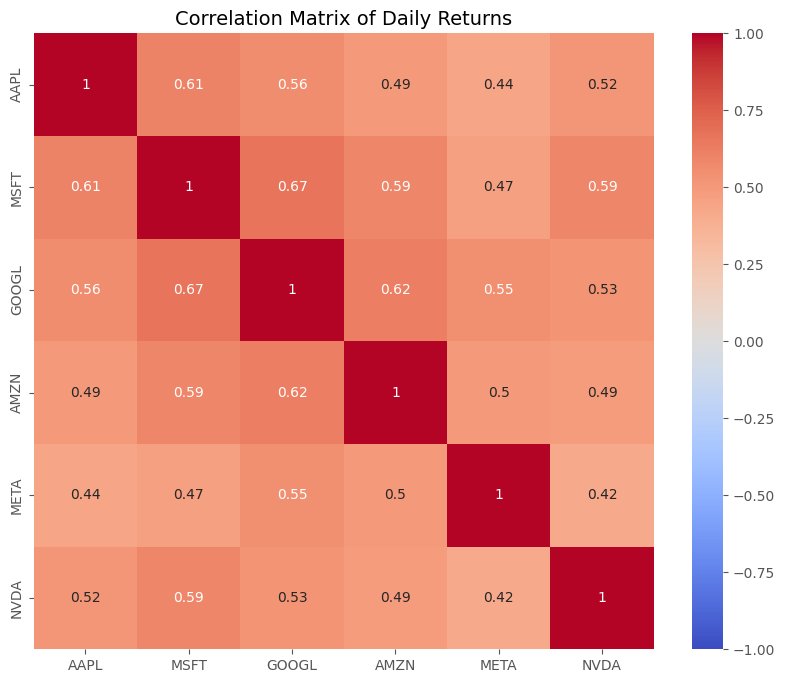


Average Correlation: 0.5358588586198614
Min Correlation: 0.4217861558483804
Max Correlation: 0.6700637935331576


In [16]:
# Calculate and plot correlation matrix
corr_matrix = daily_returns.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Daily Returns', fontsize=14)
plt.show()

# Print correlation statistics
print("\nAverage Correlation:", corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)].mean())
print("Min Correlation:", corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)].min())
print("Max Correlation:", corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)].max())

## Summary

In this notebook, we've explored:
1. How to collect financial data using the `DataCollector` class
2. Methods for calculating and analyzing returns
3. Data cleaning and validation techniques
4. Basic statistical analysis and visualization

This data will serve as the foundation for our portfolio optimization process.